In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import pickle

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

In [2]:
path = "hBigCaU0QRiYoAmlNGEYjA_94c89106c77a45a9a75a0234ad42f966_boston_housing_clean.pickle"
boston = pickle.load(open(path, "rb"))

In [3]:
boston.keys()

dict_keys(['dataframe', 'description'])

In [4]:
boston_data = boston["dataframe"]
boston_desc = boston["description"]

In [5]:
boston_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


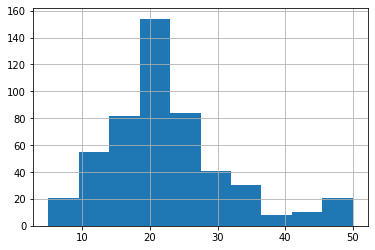

In [6]:
boston_data.MEDV.hist();

In [7]:
X = boston_data.drop("MEDV",axis=1)
y = boston_data.MEDV

In [8]:
kf = KFold(shuffle=True, n_splits=3, random_state=98625)

In [9]:
for train_index, test_index in kf.split(X):
    print("train index",train_index[:10], len(train_index))
    print("test index", test_index[:10], len(test_index))
    print("")

train index [ 1  2  3  4  6  7  8  9 12 14] 337
test index [ 0  5 10 11 13 21 22 23 27 29] 169

train index [ 0  2  3  5  9 10 11 13 15 17] 337
test index [ 1  4  6  7  8 12 14 16 18 19] 169

train index [ 0  1  4  5  6  7  8 10 11 12] 338
test index [ 2  3  9 15 17 20 24 25 28 34] 168



In [10]:
scores = []
lr = LinearRegression()

for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = (X.iloc[train_index,:],
                                        X.iloc[test_index,:],
                                        y[train_index],
                                        y[test_index])
    lr.fit(X_train, y_train)
    y_pre = lr.predict(X_test)
    score = r2_score(y_test.values, y_pre)
    scores.append(score)

scores

[0.6648344494904415, 0.7026963058682597, 0.7464441436242684]

## Scaling

In [11]:
scores = []

lr = LinearRegression()
s = StandardScaler()

for test_index, train_index in kf.split(X):
    X_train, X_test, y_train, y_test = (X.iloc[train_index,:],
                                        X.iloc[test_index,:],
                                        y[train_index],
                                        y[test_index])
    
    X_train_s = s.fit_transform(X_train)
    lr.fit(X_train_s, y_train)

    X_test_s = s.transform(X_test)
    y_pred = lr.predict(X_test_s)

    score = r2_score(y_test.values, y_pred)
    scores.append(score)


scores

[0.6897335833466052, 0.6973559967429398, 0.6510192257395004]

### `Pipeline` and `cross_val_predict`
`Pipeline` lets you chain together multiple operators on your data that both have a `fit` method.

In [12]:
s = StandardScaler()
lr = LinearRegression()

### Combine multiple processing steps into a `Pipeline`

A pipeline contains a series of steps, where a step is ("name of step", actual_model). The "name of step" string is only used to help you identify which step you are on, and to allow you to specify parameters at that step.  

In [13]:
estimator = Pipeline([("scaler", s),("regression", lr)])

### `cross_val_predict`

[`cross_val_predict`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html) is a function that does K-fold cross validation for us, appropriately fitting and transforming at every step of the way.

In [14]:
kf

KFold(n_splits=3, random_state=98625, shuffle=True)

In [15]:
predictions  = cross_val_predict(estimator,X, y, cv=kf)

In [16]:
r2_score(y, predictions)

0.7041986698315825

In [17]:
np.mean(scores)

0.6793696019430152

Note that `cross_val_predict` doesn't use the same model for all steps; the predictions for each row are made when that row is in the validation set. We really have the collected results of 3 (i.e. `kf.num_splits`) different models. 

When we are done, `estimator` is still not fitted. If we want to predict on _new_ data, we still have to train our `estimator`. 

## Hyperparameter tuning
### Definition

**Hyperparameter tuning** involves using cross validation (or train-test split) to determine which hyperparameters are most likely to generate a model that _generalizes_ well outside of your sample.

### Mechanics

We can generate an exponentially spaces range of values using the numpy [`geomspace`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.geomspace.html#numpy.geomspace) function.

```python
np.geomspace(1, 1000, num=4)
```

produces:

```
array([    1.,    10.,   100.,  1000.])
```

Use this function to generate a list of length 10 called `alphas` for hyperparameter tuning:

In [18]:
alphas = np.geomspace(1e-9, 1e0, 10)
alphas

The code below tunes the `alpha` hyperparameter for Lasso regression.

In [20]:
scores = []
coefs = []

for alpha in alphas:
    las = Lasso(alpha = alpha, max_iter=10000)

    estimator = Pipeline([("scaler",s),("lasso reg",las)])

    predictions = cross_val_predict(estimator, X, y, cv=kf)

    score = r2_score(y,predictions)

    scores.append(score)

In [21]:
list(zip(alphas, scores))

[(1e-09, 0.7041986698539051),
 (1e-08, 0.7041986700760916),
 (1e-07, 0.7041986720844802),
 (1e-06, 0.704198694306206),
 (1e-05, 0.7041988955640341),
 (0.0001, 0.7042010824403254),
 (0.001, 0.7042203638056167),
 (0.01, 0.7044421032993815),
 (0.1, 0.6995835237673349),
 (1.0, 0.653793117896433)]

In [22]:
Lasso(alpha = 1e-6).fit(X, y).coef_

In [23]:
Lasso(alpha = 1).fit(X, y).coef_

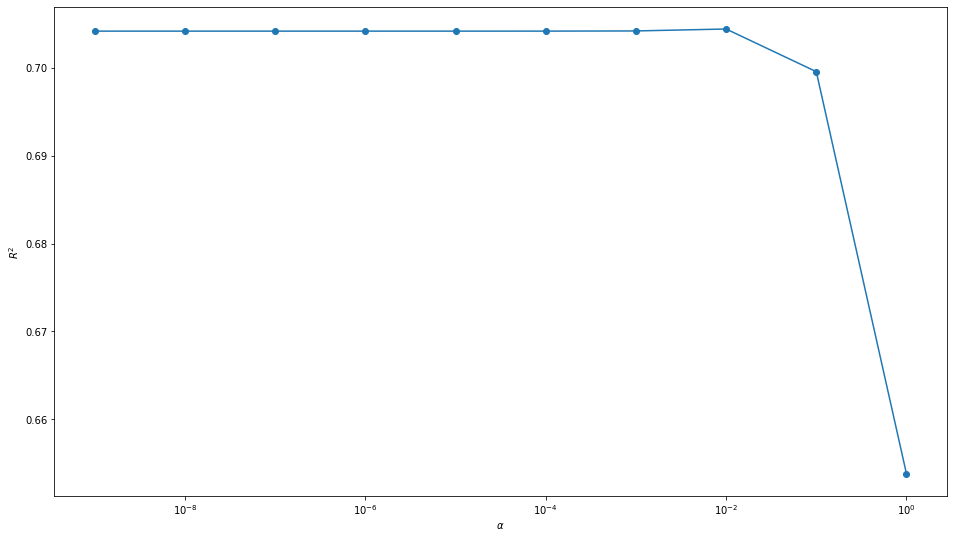

In [24]:
plt.figure(figsize=(16,9))
plt.semilogx(alphas, scores, "-o")
plt.xlabel('$\\alpha$')
plt.ylabel('$R^2$');

### Exercise

Add `PolynomialFeatures` to this `Pipeline`, and re-run the cross validation with the `PolynomialFeatures` added.

**Hint #1:** pipelines process input from first to last. Think about the order that it would make sense to add Polynomial Features to the data in sequence and add them in the appropriate place in the pipeline.

**Hint #2:** you should see a significant increase in cross validation accuracy from doing this

In [40]:
pf = PolynomialFeatures(degree=3)
scores = []
alphas = np.geomspace(0.01,1,30)
for alpha in alphas:
    las = Lasso(alpha=alpha, max_iter=10000)

    estimator = Pipeline([
        ("scaler", s),
        ("make_higher_degree", pf),
        ("lasso_regression", las)])

    predictions = cross_val_predict(estimator, X, y, cv=kf)
    score = r2_score(y,predictions)
    scores.append(score)

/opt/python/envs/default/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.212e+02, tolerance: 2.695e+00
  model = cd_fast.enet_coordinate_descent(
/opt/python/envs/default/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.037e+00, tolerance: 2.824e+00
  model = cd_fast.enet_coordinate_descent(
/opt/python/envs/default/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Du

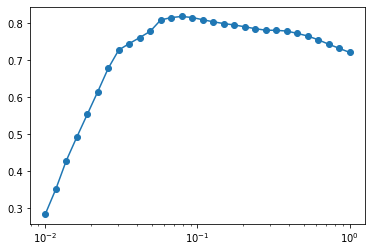

In [41]:
plt.semilogx(alphas, scores,"-o");

In [60]:
best_est = Pipeline([
                     ("scaler",s),
                     ("make_higher_degree",PolynomialFeatures(degree=2)),
                     ("Lasso_reg",Lasso(alpha = 0.09))
])


print(f'{best_est.fit(X,y)}\n{best_est.score(X,y)}')

Pipeline(steps=[('scaler', StandardScaler()),
                ('make_higher_degree', PolynomialFeatures()),
                ('Lasso_reg', Lasso(alpha=0.09))])
0.8933201803825673


In [61]:
best_est.named_steps["Lasso_reg"].coef_

### Exercise

Do the same, but with `Ridge` regression 

Which model, `Ridge` or `Lasso`, performs best with its optimal hyperparameters on the Boston dataset?

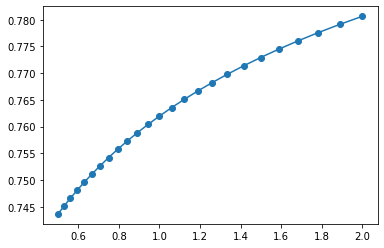

In [63]:
pf = PolynomialFeatures(degree=2)
alphas = np.geomspace(0.5, 2, 25)
scores = []

for alpha in alphas:
    rl = Ridge(alpha = alpha, max_iter=159123)

    estimator = Pipeline([
    ("scaler",s),
    ("polynomial",pf),
    ("ridge",rl)
    ])

    predictions = cross_val_predict(estimator, X, y, cv=kf)
    score = r2_score(y,predictions)
    scores.append(score)

plt.plot(alphas,scores, "-o");

Now, for whatever your best overall hyperparameter was: 

* Standardize the data
* Fit and predict on the entire dataset
* See what the largest coefficients were
    * Hint: use 
    ```python
    dict(zip(model.coef_, pf.get_feature_names()))
    ```
    for your model `model` to get the feature names from `PolynomialFeatures`.
    
    Then, use
    ```python
    dict(zip(list(range(len(X.columns.values))), X.columns.values))
    ```
    
    to see which features in the `PolynomialFeatures` DataFrame correspond to which columns in the original DataFrame.

In [64]:
best_est = Pipeline([("scaler",s),
("polynomial",PolynomialFeatures(degree = 2)),
("ridge", Ridge(alpha = 0.785 ))])

best_est.fit(X,y)
best_est.score(X,y)

0.927427938685395

In [66]:
df_importances = pd.DataFrame(zip(best_est.named_steps["polynomial"].get_feature_names(),
                            best_est.named_steps["ridge"].coef_))

In [67]:
colnames_dict = dict(zip(list(range(len(X.columns.values))),X.columns.values))

In [69]:
colnames_dict

{0: 'CRIM',
 1: 'ZN',
 2: 'INDUS',
 3: 'CHAS',
 4: 'NOX',
 5: 'RM',
 6: 'AGE',
 7: 'DIS',
 8: 'RAD',
 9: 'TAX',
 10: 'PTRATIO',
 11: 'B',
 12: 'LSTAT'}

In [70]:
df_importances.sort_values(by=1)

,0,1
90,x8^2,-4.337469
13,x12,-3.223707
8,x7,-2.752451
73,x5 x9,-2.180364
66,x4 x10,-1.937812
...,...,...
41,x2 x4,2.237398
79,x6 x8,2.983372
6,x5,3.436462
91,x8 x9,3.922790


## Grid Search CV

To do cross-validation, we used two techniques:
- use `KFolds` and manually create a loop to do cross-validation
- use `cross_val_predict` and `score` to get a cross-valiated score in a couple of lines.

To do hyper-parameter tuning, we see a general pattern:
- use `cross_val_predict` and `score` in a manually written loop over hyperparemeters, then select the best one.

Perhaps not surprisingly, there is a function that does this for us -- `GridSearchCV`

In [74]:
from sklearn.model_selection import GridSearchCV

# Same estimator as before
estimator = Pipeline([("scaler", StandardScaler()),
        ("polynomial_features", PolynomialFeatures()),
        ("ridge_regression", Ridge())])

params = {
    'polynomial_features__degree': [1, 2, 3],
    'ridge_regression__alpha': np.geomspace(4, 20, 30)
}

grid = GridSearchCV(estimator, params, cv=kf)

In [75]:
grid.fit(X,y)

GridSearchCV(cv=KFold(n_splits=3, random_state=98625, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('polynomial_features',
                                        PolynomialFeatures()),
                                       ('ridge_regression', Ridge())]),
             param_grid={'polynomial_features__degree': [1, 2, 3],
                         'ridge_regression__alpha': array([ 4.        ,  4.22826702,  4.46956049,  4.7246238 ,  4.99424274,
        5.27924796,  5.58051751,  5.89897953,  6.23561514,  6.59146146,
        6.96761476,  7.36523392,  7.78554391,  8.22983963,  8.69948987,
        9.19594151,  9.72072404, 10.27545421, 10.86184103, 11.48169104,
       12.13691388, 12.82952815, 13.56166768, 14.33558803, 15.15367351,
       16.01844446, 16.93256509, 17.89885162, 18.92028098, 20.        ])})

In [76]:
grid.best_score_, grid.best_params_

(0.8298266736008965,
 {'polynomial_features__degree': 2,
  'ridge_regression__alpha': 20.000000000000004})

In [79]:
y_predic = grid.predict(X)

In [80]:
r2_score(y, y_predic)

0.9121832001203924

In [81]:
# Notice that "grid" is a fit object!
# We can use grid.predict(X_test) to get brand new predictions!
grid.best_estimator_.named_steps['ridge_regression'].coef_

In [82]:
grid.cv_results_

{'mean_fit_time': array([0.00535822, 0.00486199, 0.00494242, 0.00497516, 0.00489744,
        0.00492748, 0.00504112, 0.0049696 , 0.00514221, 0.00539899,
        0.00522455, 0.00518401, 0.00520047, 0.00517011, 0.00523758,
        0.00521898, 0.00515556, 0.00523408, 0.00531554, 0.00518791,
        0.00516311, 0.00522685, 0.00520404, 0.00516653, 0.00523655,
        0.00525387, 0.00522741, 0.00523313, 0.00506671, 0.0052348 ,
        0.01318391, 0.0136176 , 0.01452812, 0.01411009, 0.01430058,
        0.00621819, 0.00610765, 0.00582933, 0.00581233, 0.00582592,
        0.00612815, 0.01234023, 0.01367195, 0.01425568, 0.00596428,
        0.00594608, 0.00607554, 0.00616471, 0.00575233, 0.0059003 ,
        0.01350951, 0.01412964, 0.00723322, 0.00581638, 0.00599265,
        0.00626103, 0.00658091, 0.01044385, 0.00619793, 0.00620524,
        0.01614141, 0.02496823, 0.02472488, 0.01202361, 0.01194572,
        0.01603325, 0.0251507 , 0.01587009, 0.01163753, 0.01130342,
        0.01627763, 0.02436074,

## Summary

1. We can manually generate folds by using `KFolds`
2. We can get a score using `cross_val_predict(X, y, cv=KFoldObject_or_integer)`. 
   This will produce the out-of-bag prediction for each row.
3. When doing hyperparameter selection, we should be optimizing on out-of-bag scores. This means either using `cross_val_predict` in a loop, or ....
4. .... use `GridSearchCV`. GridSearchCV takes a model (or pipeline) and a dictionary of parameters to scan over. It finds the hyperparameter set that has the best out-of-sample score on all the parameters, and calls that it's "best estimator". It then retrains on all data with the "best" hyper-parameters.

### Extensions

Here are some additional items to keep in mind:
* There is a `RandomSearchCV` that tries random combination of model parameters. This can be helpful if you have a prohibitive number of combinations to test them all exhaustively.
* KFolds will randomly select rows to be in the training and test folds. There are other methods (such as `StratifiedKFolds` and `GroupKFold`, which are useful when you need more control over how the data is split (e.g. to prevent data leakage). You can create these specialized objects and pass them to the `cv` argument of `GridSearchCV`.